In [1]:
from utils import RNN, device,SampleMetroDataset,cout_0_1
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

LEARNING_RATE = 1e-4

EPOCHS = 30

PATH = "data/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch","rb"))
ds_train = SampleMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = SampleMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length = LENGTH, stations_max = ds_train.stations_max)
data_train = DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=False)

100%|███████████████████████████████████████████| 30/30 [00:39<00:00,  1.33s/it]


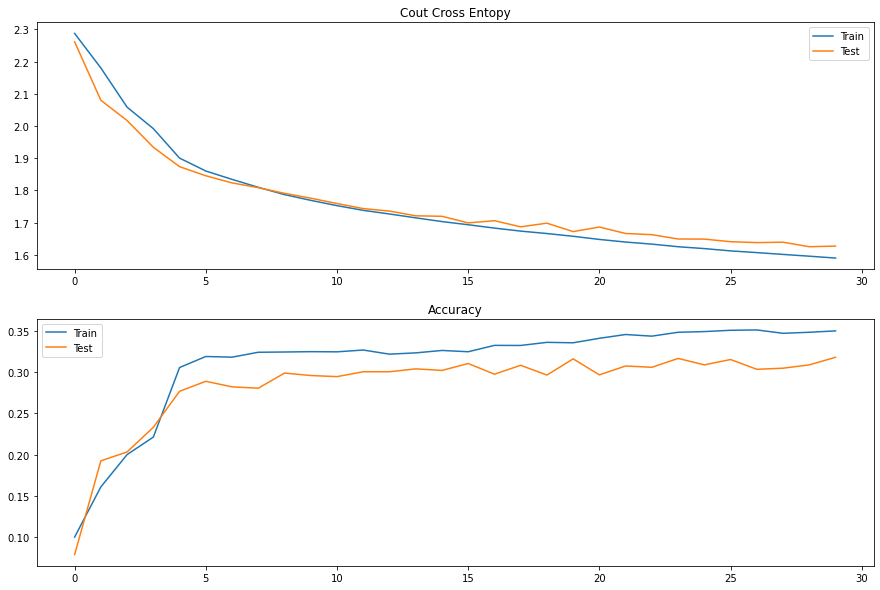

In [4]:
dim_in = DIM_INPUT
dim_lat = 30

rnn = RNN(dim_in,dim_lat,CLASSES)

CE = nn.CrossEntropyLoss()
mse = nn.MSELoss()
SGD_optimizer = torch.optim.Adam(params=rnn.parameters() ,lr=LEARNING_RATE,weight_decay=1e-5)


#  TODO:  Question 2 : prédiction de la ville correspondant à une séquence

losses_tr = []
acc_tr = []
losses_te = []
acc_te = []


for _ in tqdm(range(EPOCHS)):
    temp_loss = []
    acc = []
    for  x,y in data_train:

        # we have (batch x length x dim)
        x = x.permute(1,0,2)
        # become (length x batch x dim)
        
        SGD_optimizer.zero_grad()
        h_i , liste_h = rnn(x)

        yhat = rnn.decode(h_i,type='many-to-one')

        y_onehot = torch.eye(CLASSES)[y] 

        loss = CE(yhat,y_onehot)

        loss.backward()
        SGD_optimizer.step()
            
        with torch.no_grad():
            acc.append(1 - cout_0_1(yhat,y))
            temp_loss.append(loss.item())
        
    losses_tr.append(np.mean(temp_loss))
    acc_tr.append(np.mean(acc))

    temp_loss_te = []
    acc_tee = []
    with torch.no_grad():
        for  x,y in data_test:

            # we have (batch x length x dim)
            x = x.permute(1,0,2)
            # become (length x batch x dim)

            h_i , liste_h = rnn(x)
            yhat = rnn.decode(h_i,type='many-to-one')
            
            y_onehot = torch.eye(CLASSES)[y] 
            loss = CE(yhat,y_onehot)

            acc_tee.append(1 - cout_0_1(yhat,y))
            temp_loss_te.append(loss.item())
    
    losses_te.append(np.mean(temp_loss_te))
    acc_te.append(np.mean(acc_tee))



plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Cout Cross Entopy")
plt.plot(losses_tr,label="Train")
plt.title("Cout Cross Entopy")
plt.plot(losses_te,label="Test")
plt.legend()


plt.subplot(212)
plt.title("Accuracy")
plt.plot(acc_tr,label="Train")
plt.title("Accuracy")
plt.plot(acc_te,label="Test")
plt.legend()


plt.show()